# Intro

In this notebook I'll apply different EDA (Exploratory Data Analysis) techniques on the [Graduate Admission 2 data](https://www.kaggle.com/mohansacharya/graduate-admissions).

The goal in this data is to predict the *student's chance of admission* to a postgraduate education, given several *predictor* variables for the student.

# Import libraries

In [1]:
! pip install seaborn --upgrade

     |████████████████████████████████| 285 kB 420 kB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats

# set seaborn theme
sns.set_style(style="whitegrid")

# Load data

There are two data files:
- `Admission_Predict.csv`
- `Admission_Predict_Ver1.1.csv`
Will use the second one, since it contains more data points.

In [3]:
df = pd.read_csv("../input/graduate-admissions/Admission_Predict_Ver1.1.csv")

According to the dataset author on Kaggle, the columns in this data represents:
- `GRE Score`: The Graduate Record Examinations is a standardized test that is an admissions requirement for many graduate schools in the United States and Canada.
- `TOEFL Score`: Score in TOEFL exam.
- `University Rating`: Student undergraduate university ranking.
- `SOP`: Statement of Purpose strength.
- `LOR`: Letter of Recommendation strength.
- `CGPA`: Undergraduate GPA.
- `Research`: Whether student has research experience or not.
- `Chance of Admit`: Admission chance.

# Getting to know the data

In this section, we'll take a quick look at the data, to see how many row are there, and whther there are any missing values or not, to decie what kind of preprocessing will be needed.

In [4]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [6]:
df.shape

(500, 9)

In [7]:
df.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [8]:
df.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

The dataset consists of 500 samples and 9 columns: 8 *predictors* and one *target* variable.

There are no missing values (which is a very good thing!), but some column names need to be cleaned, and the `Serial No.` must be removed, as it has nothing to do with the student's overall admission chance.

Lookin at the `dtypes` it seems that all columns are in the correct data type, discrete columns are in `int64` and continuous in `float64`.

# Data cleaning and Preprocessing

As stated in the previous section, only few *cleaning* will be performed, mainly:
- remove extra whitespace from column names.
- drop `Serial No.` column
- convert `Research` column to bool.

In [9]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

Pandas has a great feature which allows us to apply multiple functions on the `DataFrame` in a sequential order: the [pipe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html) method.

Here, I'll define two separate functions for applying each processing step, and then call them using the `pipe` function.

In [10]:
def read_data():
    temp_df = pd.read_csv("../input/graduate-admissions/Admission_Predict_Ver1.1.csv")
    return temp_df

In [11]:
def normalize_column_names(temp_df):
    return temp_df.rename(
        columns={"LOR ": "LOR", "Chance of Admit ": "Chance of Admit"}
    )

In [12]:
def drop_noisy_columns(temp_df):
    return temp_df.drop(columns=["Serial No."])

In [13]:
def normalize_dtypes(temp_df):
    return temp_df.astype({"Research": bool, "University Rating": str})

In [14]:
def sort_uni_ranking(temp_df):
    return temp_df.sort_values(by="University Rating")

Now, we plug them together:

In [15]:
df = (
    read_data()
    .pipe(normalize_column_names)
    .pipe(drop_noisy_columns)
    .pipe(normalize_dtypes)
    .pipe(sort_uni_ranking)
)

In [16]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object')

In [17]:
df.shape

(500, 8)

In [18]:
df.dtypes

GRE Score              int64
TOEFL Score            int64
University Rating     object
SOP                  float64
LOR                  float64
CGPA                 float64
Research                bool
Chance of Admit      float64
dtype: object

We *cleaned* the data with a *clean* code!

# Exploratory Data Analysis (EDA)

In this section, we'll explore the data *visually* and summarize it using *descriptive statistic* methods.

To keep things simpler, we'll divide this section into three subsections:
1. Univariate analysis: in this section we'll focus only at one variable at a time, and study the variable descriptive statistics with some charts like: Bar chart, Line chart, Histogram, Boxplot, etc ..., and how the variable is distributed, and if there is any *skewness* in the distribution.
2. Bivariate analysis: in this section we'll study the relation between *two* variables, and present different statistics such as Correlation, Covariance, and will use some other charts like: scatterplot, and will make use of the `hue` parameter of the previous charts.
3. Multivariate analysis: in this section we'll study the relation between three or more variables, and will use additional type of charts, such as parplot.

## Univariate Analysis

Here in this section, will perform analysis on each variable individually, but according to the variable type different methods and visualization will be used, main types of variables:
- Numerical: numerical variables are variables which measures things like: counts, grades, etc ..., and they don't have a *finite* set of values, and they can be divided to:
    - Continuous: continuous variables are continous measurements such as weight, height.
    - Discrete: discrete variables represent counts such as number of children in a family, number of rooms in a house.
- Categorical: a categorical variable is a variable which takes one of a limited values, and it can be further divided to:
    - Nominal: nominal variable has a finite set of possible values, which don't have any ordereing relation among them, like countries, for example we can't say that `France` is higher than `Germany`: `France` > `Germany`, therfore, there's no sense of ordering between the values in a noinal variable.
    - Ordinal: in contrast to `Nominal` variable, ordinal varible defines an ordering relation between the values, such as the student performance in an exam, which can be: `Bad`, `Good`, `Very Good`, and `Excellent` (there's an ordering relation among theses values, and we can say that `Bad` is lower than `Good`: `Bad` < `Good`)
    - Binary: binary variables are a special case of nominal variables, but they only have *two* possible values, like admission status which can either be `Accepted` or `Not Accepted`.

resources:
- [Variable types and examples](https://www.statsandr.com/blog/variable-types-and-examples/)
- [What is the difference between ordinal, interval and ratio variables? Why should I care?](https://www.graphpad.com/support/faq/what-is-the-difference-between-ordinal-interval-and-ratio-variables-why-should-i-care/)

Let's see what are the types of variables in our dataset:

In [19]:
df.describe()

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Chance of Admit
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.00000
mean,316.472000,107.192000,3.374000,3.48400,8.576440,0.72174
std,11.295148,6.081868,0.991004,0.92545,0.604813,0.14114
min,290.000000,92.000000,1.000000,1.00000,6.800000,0.34000
25%,308.000000,103.000000,2.500000,3.00000,8.127500,0.63000
50%,317.000000,107.000000,3.500000,3.50000,8.560000,0.72000
75%,325.000000,112.000000,4.000000,4.00000,9.040000,0.82000
max,340.000000,120.000000,5.000000,5.00000,9.920000,0.97000


- Discrete: `GRE Score` and `TOEFL Score` are discrete variables.
- Continuous: `CGPA` and `Chance of Admit` are continuous variables.
- Ordinal: `University Rating`, `SOP` and `LOR` are ordinal variables.
- Binary: `Research` is a binary variable.

### `GRE Score`

The `GRE Score` is a discrete variable.

In [20]:
df["GRE Score"].describe()

count    500.000000
mean     316.472000
std       11.295148
min      290.000000
25%      308.000000
50%      317.000000
75%      325.000000
max      340.000000
Name: GRE Score, dtype: float64

In [21]:
print(df["GRE Score"].mode())

0    312
dtype: int64


In [22]:
print(stats.skew(df["GRE Score"]))

-0.03972223277299966


In [23]:
px.histogram(df, x="GRE Score", nbins=20, marginal="box")

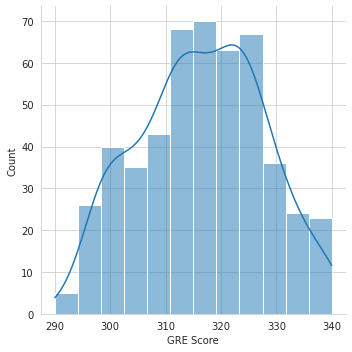

In [24]:
sns.displot(df, x="GRE Score", kind="hist", kde=True)

We can conclude from the previous charts the following:

- The GRE scores are *very close* to a normal distribution, with a small negative skewnewss (left skewed).
- The most common scores are between `310` and `325`.
- The average score is `316` with a standard deviation of `11.2`.
- There are no outliers.

This variable doesn't need any further processing.

### `TOEFL Score`

The `TOEFL Score` is a discrete variable.

In [25]:
df["TOEFL Score"].describe()

count    500.000000
mean     107.192000
std        6.081868
min       92.000000
25%      103.000000
50%      107.000000
75%      112.000000
max      120.000000
Name: TOEFL Score, dtype: float64

In [26]:
print(df["TOEFL Score"].mode())

0    110
dtype: int64


In [27]:
print(stats.skew(df["TOEFL Score"]))

0.09531393010261811


In [28]:
px.histogram(df, x="TOEFL Score", marginal="box", nbins=15)

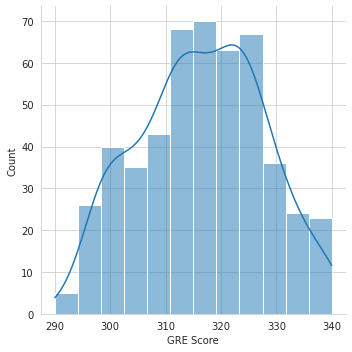

In [29]:
sns.displot(df, x="GRE Score", kind="hist", kde=True)

In [30]:
df["TOEFL Score"].value_counts()[:4]

110    44
105    37
104    29
112    28
Name: TOEFL Score, dtype: int64

From the previous charts, we can conclude:
- TOEFL scores are also normally distributed, with a small positive (right skewness).
- The average TOEFL score is `107` with a standard deviation `6`.
- The most common scores are: `110`, `105`, `104` and `112`.
- There are no outliers.

The variable doesn't need any further processing.

### `University Rating`

The `University Rating` is an ordinal variable, it represents the student's undergraduate university ranking on a scale 1-5.

In [31]:
df["University Rating"].value_counts()

3    162
2    126
4    105
5     73
1     34
Name: University Rating, dtype: int64

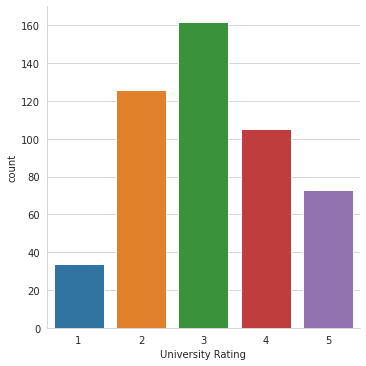

In [32]:
sns.catplot(data=df, x="University Rating", kind="count")

In [33]:
temp_df = df.groupby(by="University Rating", as_index=False).agg(
    counts=pd.NamedAgg(column="University Rating", aggfunc="count")
)

In [34]:
temp_df["University Rating"] = temp_df["University Rating"].astype(str)

In [35]:
px.bar(
    data_frame=temp_df,
    x="University Rating",
    y="counts",
    color="University Rating",
    color_discrete_sequence=px.colors.qualitative.D3,
)

We can see that the most common rating is in the middle: `3`. The chart shows that the ratings are distributed in a similar fashion to the normal distrbution.

### `SOP`

`SOP` stands for the strength of *Statement of Purpose* which is a necessary document for graduate applications. The values were (mostly) entered by the students, and it's on scale 1-5, so this is an ordinal variable.

In [36]:
df["SOP"].value_counts()

4.0    89
3.5    88
3.0    80
2.5    64
4.5    63
2.0    43
5.0    42
1.5    25
1.0     6
Name: SOP, dtype: int64

In [37]:
temp_df = df.groupby(by="SOP", as_index=False).agg(
    counts=pd.NamedAgg(column="SOP", aggfunc="count")
)

In [38]:
temp_df["SOP"] = temp_df["SOP"].astype(str)

In [39]:
px.bar(
    data_frame=temp_df,
    x="SOP",
    y="counts",
    color="SOP",
    color_discrete_sequence=px.colors.qualitative.Prism,
)

Most students estimated the strength of their *Statement of Purpose* between `3` and `4`.

### `LOR`

`LOR` stands for the strength of *Letter of Recommendation*. The values were (mostly) entered by the students, and it's on scale 1-5, so this is an ordinal variable.

In [40]:
df["LOR"].value_counts()

3.0    99
4.0    94
3.5    86
4.5    63
5.0    50
2.5    50
2.0    46
1.5    11
1.0     1
Name: LOR, dtype: int64

In [41]:
temp_df = df.groupby(by="LOR", as_index=False).agg(
    counts=pd.NamedAgg(column="LOR", aggfunc="count")
)

In [42]:
temp_df["LOR"] = temp_df["LOR"].astype(str)

In [43]:
px.bar(
    data_frame=temp_df,
    x="LOR",
    y="counts",
    color="LOR",
    color_discrete_sequence=px.colors.qualitative.Prism,
)

Most of the students rated the strength of ther *Letter of Recommendation* between `3` and `4`.

### `CGPA`

The `CGPA` stands for the student's *cumulative grade point average*, which represents the average of grade points obtained in all the subjects by the student.

It's a continuous variable, on a scale 0-10.

In [44]:
df["CGPA"].describe()

count    500.000000
mean       8.576440
std        0.604813
min        6.800000
25%        8.127500
50%        8.560000
75%        9.040000
max        9.920000
Name: CGPA, dtype: float64

In [45]:
print(stats.skew(df["CGPA"]))

-0.026532613141817388


In [46]:
px.histogram(data_frame=df, x="CGPA", marginal="box", nbins=12)

As we can see, this variable is *very* close to a normal distribution, with a small negative (left) skewness, and there are no outliers.

### `Research`

The `Research` variable indicates whether the student has any research experience or not, so it's a `Binary` variable.

Although, it would be better to have a variable like `Research duration` which expresses for how long was the student involved in a research activity.

In [47]:
df["Research"].value_counts()

True     280
False    220
Name: Research, dtype: int64

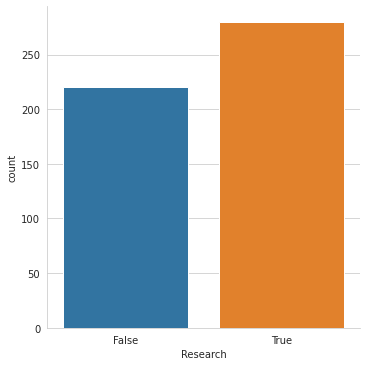

In [48]:
sns.catplot(data=df, x="Research", kind="count")

In [49]:
temp_df = df.groupby(by="Research", as_index=False).agg(
    counts=pd.NamedAgg(column="Research", aggfunc="count")
)

In [50]:
px.bar(
    data_frame=temp_df,
    x="Research",
    y="counts",
    color="Research",
    color_continuous_scale=px.colors.qualitative.D3,
)

From this plot, we can see that the number of students who have a research experience is *almost* equal to the number of students who don't.

Later, we'll study the relation of this variable with other variables.

### `Chance of Admit`

Quoting the dataste author from this [thread](https://www.kaggle.com/mohansacharya/graduate-admissions/discussion/79063#464899):

> chance of admit is a parameter that was asked to individuals (some values manually entered) before the results of the application

So thie column is not an actual *probability of admission* estimated by the universities or something, rather, it's an estimation by the student themselves of how likely they'll be admitted to the university.

In [51]:
df["Chance of Admit"].describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit, dtype: float64

In [52]:
print(stats.skew(df["Chance of Admit"]))

-0.2890955854789938


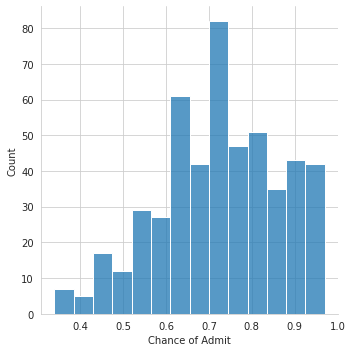

In [53]:
sns.displot(data=df, x="Chance of Admit")

In [54]:
px.histogram(data_frame=df, x="Chance of Admit", marginal="box")

In [55]:
df[df["Chance of Admit"] < 0.36]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
376,297,96,2,2.5,2.0,7.43,False,0.34
92,298,98,2,4.0,3.0,8.03,False,0.34


The plot shows that most student estimated their chance of admission between `0.7` and `0.75`.

The distribution is *moderately* skewed to the left with a negative skew value `-0.29`.

There are also two outlier values `0.34`.

## Bivariate Analysis

In this section, we'll focus on studying the relationship between two different variables, to answer different question, like
- What is the relation between variable `x` and variable `y`? is it linear or non-linear?
- In case of a linear relation, is positive linear relation or negative linear relation? and how *strong* is the relation?
- How the distribution for two variables changes?

### Correlation matrix

We'll start off by computing the correlation matrix using `.corr` method of pandas, which computes the pairwise correlation of columns.

The method used for calculating the correlation between two variables `x` and `y` is the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

The pearson coefficient is a measure of the linear correlation between two variables `x` and `y`, and it takes values between `-1` and `+1`.

A negative value indicates a negative correlation (i.e. when one variable *increases* the other *decreases*), and a positive value is the opposite (the two variables *increases*/*decreases* at the same time)

![Correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png)

Here, we'll compute the correlations only for `GRE Score`, `TOEFL Score` and `CGPA` variables, because they are *numeric* variables, and they weren't estimated by the students themselves.

In [56]:
numeric_cols = ["GRE Score", "TOEFL Score", "CGPA"]

In [57]:
corr = df[numeric_cols].corr()

In [58]:
px.imshow(
    corr,
    color_continuous_scale="PuBu",
    color_continuous_midpoint=0.6,
    title="Correlation matrix",
)

We can see from the correlation matrix that the three variables have a strong positive correlation. We'll look closer at the relations between variables using scatter plots.

### Scatter plot

Scatter plots are a good way to show the spread of points for two variables `x` and `y`, and view the relation between the two variables (e.g. linear, non-linear, ...) and the trend of the linear relation (positive, negative)

An easy way to show multiple scatter plots on the same figure is either using `scatter_matrix` or `pairplot`.

In [59]:
fig = px.scatter_matrix(
    df,
    dimensions=numeric_cols,
    title="Scatter matrix of student's TOEFL Score, GRE Score, and CGPA",
)

fig.show()

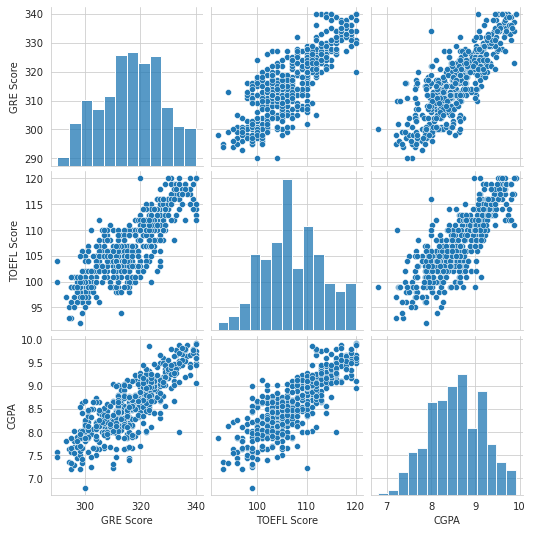

In [60]:
sns.pairplot(data=df, vars=numeric_cols)

It's evident from these plots that the relation between the variables is positive linear relation, with some outlier points, and they all have an upward trend.

Let's show the scatter for each two variables at a time:

#### `TOEFL Score` vs. `GRE Score`

In [61]:
corr_value = df["TOEFL Score"].corr(df["GRE Score"])

fig = px.scatter(
    data_frame=df,
    x="TOEFL Score",
    y="GRE Score",
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",
    trendline_color_override="red",
    title=f"Correlation between TOEFL Score and GRE Score is: {corr_value:.2f}",
)

fig.show()

#### `TOEFL Score` vs. `CGPA`

In [62]:
corr_value = df["TOEFL Score"].corr(df["CGPA"])

fig = px.scatter(
    data_frame=df,
    x="TOEFL Score",
    y="CGPA",
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",
    trendline_color_override="red",
    title=f"Correlation between TOEFL Score and CGPA is: {corr_value:.2f}",
)

fig.show()

#### `GRE Score` vs. `CGPA`

In [63]:
corr_value = df["GRE Score"].corr(df["CGPA"])

fig = px.scatter(
    data_frame=df,
    x="GRE Score",
    y="CGPA",
    marginal_x="histogram",
    marginal_y="histogram",
    trendline="ols",
    trendline_color_override="red",
    title=f"Correlation between GRE Score and CGPA is: {corr_value:.2f}",
)

fig.show()

From the previous three charts we can say that: students who perform well in their `TOEFL` exams tend to also perform well in `GRE` exams, and they *mostly* have high `GPA` (higher than 9).

### Bivariate distributions

Another way to study the relation between two variables is with 2D Histograms (distribution).

Just like the distributions we used in the **Univariate Analysis** section, we can show the distribution for two variables `x` and `y`, which would give us better insights on how much the values from the two variables overlap, and show cluster regions in the 2D space.

Compared to scatter plots, 2D histograms are better at handling large amounts of data, as they use rectangular bins, and count the number of points withing each bin.

#### `TOEFL Score` vs. `GRE Score`

In [64]:
fig = px.density_heatmap(
    data_frame=df, x="TOEFL Score", y="GRE Score", color_continuous_scale="PuBu"
)

fig.show()

We can see from this chart some *clusters* (regions).

For example there are two clusters of students who scored between `110` and `115` in the `TOEFL` exam and between `320` and `330` in the `GRE` exam. These two clusters account for about 100 students (which is 20% of the total dataset).

#### `TOEFL Score` vs. `CGPA`

In [65]:
fig = px.density_heatmap(
    data_frame=df, x="TOEFL Score", y="CGPA", color_continuous_scale="PuBu"
)

fig.show()

This chart shows that about `170` students has `TOEFL` score in range `[105-115]` and their `CGPA` is in range `[8-9]`

#### `GRE Score` vs. `CGPA`

In [66]:
fig = px.density_heatmap(
    data_frame=df, x="GRE Score", y="CGPA", color_continuous_scale="PuBu"
)

fig.show()

This chart shows that almost `120` students has `GRE` scores in the range `[310-320]` and their `CGPA` is in thae range `[8-9]`.

### `Research`

One interesting question would be: How does research experience affects other variables? Do students who have research experience have beeter *CGPA*? Do they have better scores in *TOEFL* or *GRE* (or both)?

We can display the same distributions we used in the *Univariate analysis* section, with conditioning on `Research` variable:

In [67]:
px.histogram(data_frame=df, x="TOEFL Score", color="Research", barmode="group")

In [68]:
px.histogram(data_frame=df, x="GRE Score", color="Research", barmode="group")

In [69]:
px.histogram(data_frame=df, x="CGPA", color="Research", barmode="group")

We can see that students who engage in research activities and have research experience, tend to perform better in both *TOEFL* and *GRE* exams, and they have higher *GPA*, in comparison to students who have no research experience.

### `University Rating`

The `University Rating` variable represents the ranking of the university from which the student graduated.

We might ask: How does the relation between student different scores changes for different university ranking?

Let's see how the university ranking affects student's scores and GPA:

In [70]:
px.histogram(
    data_frame=df,
    x="TOEFL Score",
    color="University Rating",
    barmode="group",
    color_discrete_sequence=px.colors.sequential.Blugrn,
)

In [71]:
px.histogram(
    data_frame=df,
    x="GRE Score",
    color="University Rating",
    color_discrete_sequence=px.colors.sequential.Blugrn,
    barmode="group",
)

In [72]:
px.histogram(
    data_frame=df,
    x="CGPA",
    color="University Rating",
    color_discrete_sequence=px.colors.sequential.Blugrn,
    barmode="group",
)

The university ranking plays an important role in student's scores and GPA, we can observe that students who go to higher ranking universities, have higher scores in the *TOEFL* and *GRE* exams, and they have higher *GPA*.

## Multivariate Analysis

So far, all the plots we used before were used either to explore one variable, or to show the relation between a pair of variables.

However, we are often interested in answering the question: **How does the relation between two variables changes as a function of a *third* variable?**

In this section, we'll focus on answering these kinds of questions, where we'll use similar plots to the ones we used before, with conditioning on other variable.

### Scatter matrix with `Research`

We start by plotting the scatter matrix for variables `TOEFL Score`, `GRE Score` and `CGPA` (just as we did in bivariate analysis section), with showing the relation to `Research` variable with color coding.

This will draw an overall picture of how these variables are related to each other, and how this relation changes when whether student has a research experience or not.

In [73]:
px.scatter_matrix(
    data_frame=df,
    dimensions=numeric_cols,
    color="Research",
    title="Scatter matrix for TOEFL Score, GRE Score, and CGPA conditioning on Research variable",
)

We can how students who have research experience tend to have higher scores and better GPA.

### Bivariate distribution with `University Rating`

As we saw earlier, the ranking of student's university plays an important role in other variables, and higher university ranking is linked with better performance in TOEFL and GRE exams, and higher GPA.

Here, we'll show the bivariate distribution of each pair of variables, for different university ranking values.

This way, we will be able to study the relation between two variables `x` and `y` as a function of the university ranking value.

#### `TOEFL Score` vs. `GRE Score`

In [74]:
px.density_heatmap(
    data_frame=df,
    x="TOEFL Score",
    y="GRE Score",
    color_continuous_scale="PuBu",
    facet_col="University Rating",
    title="TOEFL Score vs. GRE Score for different university ranking values",
)

#### `TOEFL Score` vs. `CGPA`

In [75]:
px.density_heatmap(
    data_frame=df,
    x="TOEFL Score",
    y="CGPA",
    facet_col="University Rating",
    color_continuous_scale="PuBu",
    title="TOEFL Score vs. CGPA for different university ranking values",
)

#### `GRE Score` vs. `CGPA`

In [76]:
px.density_heatmap(
    data_frame=df,
    x="GRE Score",
    y="CGPA",
    facet_col="University Rating",
    color_continuous_scale="PuBu",
    title="GRE Score vs. CGPA for different university ranking values",
)

All these charts support our previous hypothesis: **University ranking influences positively student's performance.**

### `Research` and `University Rating`

In all previous plots we used either the `Research` variable or `University Rating` variable, however, it would very helpful to see how these two variables interact with each other, and how other vriables interact with them.

Here, we'll use scatterplot to show relation between two variables `x` and `y`, and show how this relation changes for different values of `Research` and `University Rating`.

This would be useful for answering questions:

- Do students who go to higher-ranking universitries, are more involved in research activiteis?
- How research experience and university ranking influence student's performance in exams and GPA?
- Are there any outlier points? 

#### `TOEFL Score` vs. `GRE Score`

In [77]:
px.scatter(
    data_frame=df,
    x="TOEFL Score",
    y="GRE Score",
    color="Research",
    facet_col="University Rating",
    trendline="ols",
    symbol="Research",
)

#### `TOEFL Score` vs. `CGPA`

In [78]:
px.scatter(
    data_frame=df,
    x="TOEFL Score",
    y="CGPA",
    color="Research",
    facet_col="University Rating",
    trendline="ols",
    symbol="Research",
)

#### `GRE Score` vs. `CGPA`

In [79]:
px.scatter(
    data_frame=df,
    x="GRE Score",
    y="CGPA",
    color="Research",
    facet_col="University Rating",
    trendline="ols",
    symbol="Research",
)

As we can see, higher university ranking is linked with research experience, and they both affects student's scores and GPA.

We can also see that there are some *outlier* points, where student goes to a low-ranking university and has no research experience, but have *good* scores.

This way of studying a how the relation between two variables changes as a function to other variables is very useful when we have a ver large amount of data, and we want to study the relation between two *quanitative variables*, and how this relation changes with respect to other *categorical variables*, as we will have fewer points to investigate, rather than a single scatter plot with too many points.